# Sleep vs. School

Lucy Turner

Quantified Self: Final Project for Gonzaga CPSC 222, Spring 2022

## Introduction


For Sleep vs. School, I am studying the impact of the number of assignments I have due on the amount of sleep I get per night and the quality of my sleep. The data I used was from a Whoop fitness tracker and my manually inputted assignment list in excel. I hypothesized that the higher the number of assignments I had due, the less quality sleep I would get. I used a kNN model and a decision tree to see if I could model these behaviors. 

I converted both data sets to csv files in order to utilize them for this project. I modeled the data in multiple ways, the most informative being number of hours of sleep by number of assignments, and frequency of total hours of sleep. 

I would like to classify the number of assignments I had due and whether a given day was a weekend or a weekday so that the data can be informative to potential lesson plans and for my own tracking of productivity to prevent burnout. Potential stakeholders could be professors in charge of lesson plans and assignment schedules, as well as other students looking to maximize their productivity. 


For the first dataset, we will be working with health data from a [Whoop fitness tracker](https://www.whoop.com).

The Whoop health dataset contains 326 instances with the following attributes: 
* date
* Strain Score
* Avg Heart Rate - Beats / min
* Heart Rate Variability - Milliseconds
* Max Heart Rate - Beats / min
* Resting Heart Rate - Beats / min
* Total Calories Burned - Calories
* Recovery Score - %
* Deep Sleep - Hours
* Deep Sleep Percent - %
* Light Sleep - Hours
* Light Sleep Percent - %
* Nap Count - Naps
* Nap Sleep - Hours
* REM Sleep - Hours
* REM Sleep Percent - %
* Sleep End Time - 24-hour time
* Sleep Score - %
* Sleep Start Time - 24-hour time
* Time Awake - Hours
* Time in Bed - Hours
* Total Sleep - Hours
* Sleep Consistency - %
* Sleep Cycles - Cycles
* Sleep Disturbances - Disturbances
* Sleep Disturbances / Hour - Disturbances
* Sleep Disturbances Duration - Minutes
* Sleep Onset Latency - Minutes
* Sleep Respiratory Rate - Breaths / min
* Time Asleep Percent - %
* Time Awake Percent - %

The attributes fall under the following categories:  
Activity,Heart,Heart,Heart,Heart,Metabolism,Recovery,Sleep Length,Sleep Length,Sleep Length,Sleep Length,Sleep Length,Sleep Length,Sleep Length,Sleep Length,Sleep Length,Sleep Length,Sleep Length,Sleep Length,Sleep Length,Sleep Length,Sleep Quality,Sleep Quality,Sleep Quality,Sleep Quality,Sleep Quality,Sleep Quality,Sleep Quality,Sleep Quality,Sleep Quality

The Assignments dataset contains 103 instances with the following attributes:
* Date
* Assignments

From this data, once joined with the health data, I will create the additional columns "Number of Assignments", "Day of the Week", and "Weekday"

## Data Analysis

### Cleaning

The first step was to load the data from both csv files into [pandas DataFrame objects](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html?highlight=dataframe#pandas.DataFrame). We did this using [pandas.read_csv](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html?highlight=read_csv#pandas.read_csv)

In [1]:
import pandas as pd
import utils as u
whoop_df = pd.read_csv('raw_health_data.csv', index_col=0)
assignments_df = pd.read_csv('assignments_by_date.csv')

##### Woop Data Cleaning

To clean this data, we will use DataFrame method [pandas.DataFrame.interpolate](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.interpolate.html?highlight=interpolate#pandas.DataFrame.interpolate) to fill middle values that are missing, or NaN. We used `ffill()` and `bfill()`, forwards and backwards fill methods of [pandas.DataFrame.fillna](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html#pandas.DataFrame.fillna) to ensure that no end values are missed.

In [2]:
whoop_df.interpolate(method='linear', inplace=True)
whoop_df.fillna(method='ffill', inplace=True)
whoop_df.fillna(method='bfill', inplace=True)

Looking at the resulting DataFrame, we decided that we wanted to focus only on sleep data in connection to assignments for the semester, so for this project we will only be working with sleep and assignment data from 1/11/22.

We will form a new DataFrame that only includes the columns in `whoop_df` that we want to continue working with. 

These columns are:
* Deep Sleep - Hours
* Deep Sleep Percent - %
* Light Sleep - Hours
* Light Sleep Percent - %
* Nap Count - Naps
* Nap Sleep - Hours
* REM Sleep - Hours
* REM Sleep Percent - %

We call `.loc['2022-01-11':]` on the resulting DataFrame to obtain the slice of data in the correct date range.

Finally, we convert the index column to a pandas datetime object using [pandas.to_datetime](https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html?highlight=to_datetime#pandas.to_datetime).

In [3]:
sleep_hw_df = whoop_df.drop(columns=['Strain Score', 'Avg Heart Rate', 'Heart Rate Variability', 'Max Heart Rate', 'Resting Heart Rate', 'Total Calories Burned',
       'Recovery Score', 'Sleep End Time', 'Sleep Score', 'Sleep Start Time', 'Time Awake', 'Time in Bed',
       'Sleep Consistency', 'Sleep Cycles', 'Sleep Disturbances', 'Sleep Disturbances / Hour', 'Sleep Disturbances Duration', 
       'Sleep Onset Latency', 'Sleep Respiratory Rate', 'Time Asleep Percent', 'Time Awake Percent']).loc['2022-01-11':]
sleep_hw_df.index = pd.to_datetime(sleep_hw_df.index)
print(sleep_hw_df)

            Deep Sleep  Deep Sleep Percent  Light Sleep  Light Sleep Percent  \
date                                                                           
2022-01-11    1.093341           15.186658     5.727659            79.557996   
2022-01-12    0.916865           14.871207     3.689389            59.840494   
2022-01-13    0.965797           15.339545     4.246074            67.439501   
2022-01-14    1.497095           21.034635     4.390751            61.691359   
2022-01-15    0.748144           12.801974     4.380313            74.954344   
2022-01-16    0.803762           11.334004     4.744484            66.902886   
2022-01-17    1.159650           18.815634     3.119309            50.611646   
2022-01-18    0.916866           18.131365     2.982159            58.973290   
2022-01-19    0.153211            2.845344     4.644224            86.249883   
2022-01-20    1.494956           25.020212     2.395233            40.087628   
2022-01-21    0.900558           14.3956

##### Assignments Data Cleaning

To clean the Assignments data, we converted the "Date" column to a pandas datetime object using `pd.to_datetime()`. See to_datetime documentation [here](https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html). The resulting DataFrame has a numerical index because the 'Date' column contains duplicate dates on days where there are multiple assignments due. The "Assignments" column contained the name of every assignment that was due, which is not helpful in a classification model. To fix these issues and add a "Number of Assignments" column instead of a string assignment name column, we created a dictionary containing the number of assignments by date, and converted this dictionary to a new DataFrame. 

In [4]:
assignments_df['Date'] = pd.to_datetime(assignments_df['Date'])
num_assignments = {}
for date, dates in assignments_df.groupby('Date'):
    num_assignments[date] = dates['Assignments'].count()
num_ass_df = pd.DataFrame.from_dict(num_assignments, orient='index', columns=['Number of Assignments'])
print(num_ass_df)

            Number of Assignments
2022-01-11                      1
2022-01-13                      1
2022-01-16                      1
2022-01-18                      3
2022-01-20                      3
2022-01-23                      1
2022-01-24                      1
2022-01-25                      3
2022-01-27                      2
2022-01-30                      1
2022-01-31                      1
2022-02-01                      3
2022-02-03                      2
2022-02-06                      1
2022-02-07                      1
2022-02-08                      3
2022-02-09                      1
2022-02-10                      2
2022-02-14                      1
2022-02-15                      4
2022-02-17                      2
2022-02-21                      1
2022-02-22                      4
2022-02-24                      2
2022-02-27                      1
2022-02-28                      1
2022-03-01                      3
2022-03-02                      1
2022-03-03    

#### Merging

To merge the two datasets, we used the [pandas.DataFrame.join()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.join.html) method. We chose to use `.join()` because it runs a left join by default. A left join is appropriate here because we wanted to add columns to our original sleep DataFrame for the assignments data, without losing any dates. We call `.fillna(0)` on the resulting DataFrame to ensure that dates with no assignments due are appropriately updated to show 0 assignments due. 

In [5]:
sleep_hw_df = sleep_hw_df.join(num_ass_df)
sleep_hw_df['Number of Assignments'] = sleep_hw_df['Number of Assignments'].fillna(0)

Finally, we added "Day of the Week" and "Weekday" columns to easily track the day of the week each date is representing and whether or not that day is a weekday (1 is weekday, 0 is weekend). We used the `weekday()` method from python's [datetime class](https://docs.python.org/3/library/datetime.html) to easily set up a "Day of Week" column.

In [6]:
sleep_hw_df['Day of Week'] = [date.weekday() for date in sleep_hw_df.index]
sleep_hw_df['Weekday'] = [0 if day > 4 else 1 for day in sleep_hw_df['Day of Week']]
sleep_hw_df.to_csv('sleep_assignment_data.csv')
print(sleep_hw_df)

            Deep Sleep  Deep Sleep Percent  Light Sleep  Light Sleep Percent  \
date                                                                           
2022-01-11    1.093341           15.186658     5.727659            79.557996   
2022-01-12    0.916865           14.871207     3.689389            59.840494   
2022-01-13    0.965797           15.339545     4.246074            67.439501   
2022-01-14    1.497095           21.034635     4.390751            61.691359   
2022-01-15    0.748144           12.801974     4.380313            74.954344   
2022-01-16    0.803762           11.334004     4.744484            66.902886   
2022-01-17    1.159650           18.815634     3.119309            50.611646   
2022-01-18    0.916866           18.131365     2.982159            58.973290   
2022-01-19    0.153211            2.845344     4.644224            86.249883   
2022-01-20    1.494956           25.020212     2.395233            40.087628   
2022-01-21    0.900558           14.3956

#### Challenges

The largest challenges we faced when cleaning and merging this dataset were working with missing values in the Whoop data, and working with the datetime objects in the Assignments data to come up with a table that could be logically joined with the Whoop data. See [Whoop Data Cleaning](#woop-data-cleaning) and [Assignments Data Cleaning](#assignments-data-cleaning) for documentation of challenge solutions.

#### Data Aggregation Techniques

We used the [pandas.DataFrame.join()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.join.html) method. We chose to use `.join()` because it runs a left join by default. A left join is appropriate here because we wanted to add columns to our original sleep DataFrame for the assignments data, without losing any dates. See [Merging](#merging) for more information.

### Visualizations

Using [matplotlib.pyplot](https://matplotlib.org/stable/api/pyplot_summary.html?highlight=pyplot), we created the following visualizations.

The following visualization shows the breakdown of average hours of sleep per night by category. The categories are:
* Nap sleep
* Light Sleep
* Deep Sleep
* Rem Sleep

After analyzing this visualization, we concluded that for further data analysis Deep and Rem sleep should be combined into a singular category.

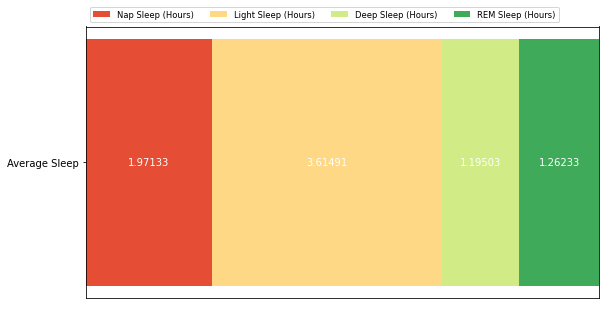

In [7]:
nap_avg = sleep_hw_df['Nap Sleep'].mean()
light_avg = sleep_hw_df['Light Sleep'].mean()
deep_avg = sleep_hw_df['Deep Sleep'].mean()
rem_avg = sleep_hw_df['REM Sleep'].mean()
sleep_categories = ['Nap Sleep (Hours)', 'Light Sleep (Hours)', 'Deep Sleep (Hours)', 'REM Sleep (Hours)']
results = [nap_avg, light_avg, deep_avg, rem_avg]

u.banded_bars(categories=sleep_categories, cat_labels=['Average Sleep'], results=results)

Number of Assignments by Sleep

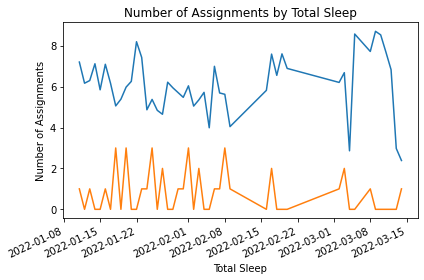

In [8]:
import matplotlib.pyplot as plt
u.plot_from_df(sleep_hw_df, 'Total Sleep', 'Number of Assignments', x_label='Total Sleep', y_label='Number of Assignments', title='Number of Assignments by Total Sleep')

Number of Days with x number of assignments due, separated by Weekday or Weekend. We can see from this graph that no weekend had more than 1 Assignment due. 

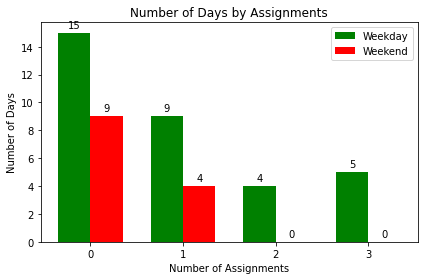

In [9]:
label_decoder = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}
u.grouped_bar_chart(sleep_hw_df, grouping='Weekday', groupby='Number of Assignments', x_label='Number of Assignments', y_label='Number of Days', \
    title='Number of Days by Assignments', group1=1, group2=0, group1_label='Weekday', group2_label='Weekend', label_decoder=label_decoder, how='count')

Total Sleep per Night in Hours

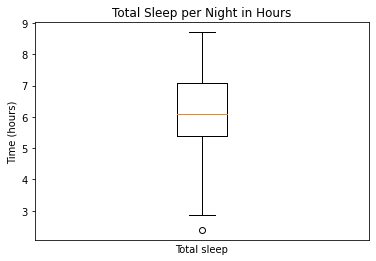

In [10]:
sleep_ser = sleep_hw_df['Total Sleep']
u.box_and_whisker(sleep_ser, y_label='Time (hours)', x_label='Total sleep', title='Total Sleep per Night in Hours')

This graph represents total sleep frequencies. 

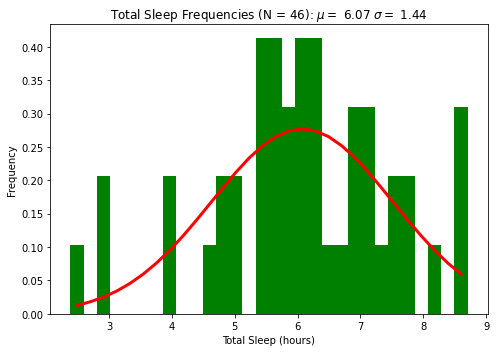

In [11]:
u.hist_trend(sleep_ser, x_label='Total Sleep (hours)', y_label='Frequency', title='Total Sleep Frequencies')

This is the same visualization from above for a period of a year instead of just the semester. We see that the mean is considerably higher, indicating a decline in sleep once the semester began. 

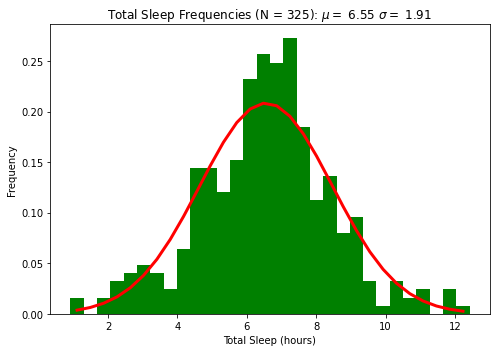

In [12]:
total_sleep_ser = whoop_df['Total Sleep']
u.hist_trend(total_sleep_ser, x_label='Total Sleep (hours)', y_label='Frequency', title='Total Sleep Frequencies')

Number of Assignments and Hours of Sleep

Text(0.5, 1.0, 'Number of Assignments and Hours of Sleep')

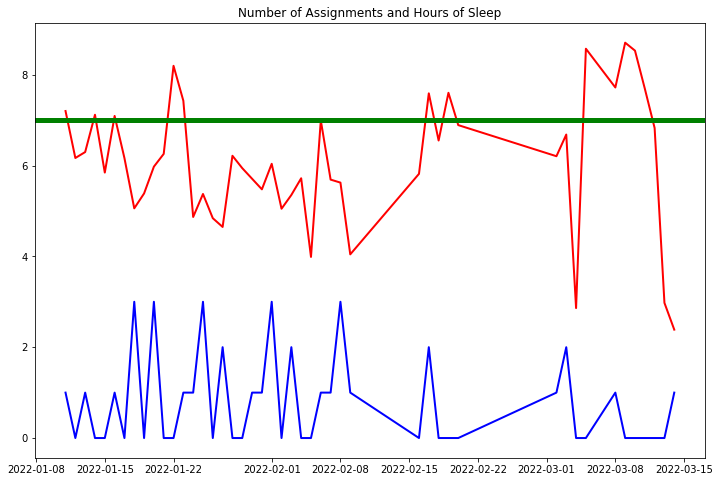

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(sleep_ser, color='red', lw=2)
ax.plot(sleep_hw_df['Number of Assignments'], color='blue', lw=2)
ax.axhline(y=7, color='green', lw=5)
plt.title("Number of Assignments and Hours of Sleep")

### Hypothesis Testing

##### Average Sleep is greater than 7 hours per night

Identifying null and alternative Hypotheses:
* $H_{0} = \mu_{Total Sleep} >= 7$
* $H_{1} = \mu_{Total Sleep} < 7$

Level of Significance:
* $\alpha = .05$

Test Statistic:
* t-test
$$t=\frac{\overline{x} - \mu}{s / \sqrt{n}}$$

Because this test was done as an analysis of the data rather than as a comparative between two data sets, we will use [scipy.stats.ttest_1samp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_1samp.html)

H0: $\mu$ sleep $\leq$ 7 hours

H1: $\mu$ sleep $>$ 7 hours

In [14]:
alpha = 0.025
hypothesized_pop_mean = 7
u.t_test_one(sleep_hw_df['Total Sleep'], hypothesized_pop_mean, alpha=alpha, test_type='one-tailed')

Reject H0. t: -4.368606895186374, p: 3.635704750740347e-05


Running the same test with total data

In [15]:
alpha = 0.025
hypothesized_pop_mean = 7
u.t_test_one(whoop_df['Total Sleep'], hypothesized_pop_mean, alpha=alpha, test_type='one-tailed')

Reject H0. t: -4.205434597130122, p: 1.6880091734565745e-05


##### Total Sleep varies inversely with Number of Assignments

H0: average sleep does not correlate with number of assignments

H1: average sleep varies inversely with assignment due count 

Running a t-test using [scipy.stats.ttest_ind](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html) did not provide adequate information on this hypothesis. 

In [16]:
test_data = sleep_hw_df.drop(columns=['Deep Sleep', 'Deep Sleep Percent', 'Light Sleep', 'Light Sleep Percent', 'Nap Count', 'Nap Sleep', 'REM Sleep', \
       'REM Sleep Percent','Day of Week', 'Weekday'])
test_data = u.scale(test_data, 'Total Sleep', 'Number of Assignments') # scales using min/max scaling
u.t_test_two(test_data['Total Sleep'], test_data['Number of Assignments'], alpha=0.05, test_type='two-tailed')

Reject H0. t: 5.383710037068445, p: 7.258762444826689e-07


Using [scipy.stats.pearsonr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html#scipy.stats.pearsonr), we can instead run a linear correlation test

In [17]:
import scipy.stats as stats
r, p_val = stats.pearsonr(test_data['Total Sleep'], test_data['Number of Assignments'])
print(f'r: {r}, p_val: {p_val}')

r: -0.13406721098397986, p_val: 0.3743882750136583


Accept H0: Number of Assignments does not correlate inversely with Total Sleep

The previous code implies no linear correlation. In further studies, researches would likely have a better result testing for a different kind of correlation. 

##### Total Sleep is lower on days with more assignments due

Identifying null and alternative Hypotheses:
* $H_{0} = \mu_{Total Sleep on days with 0 assignments} \leq \mu_{Total Sleep on days with 2+ assignments}$
* $H_{1} = \mu_{Total Sleep on days with 0 assignments} > \mu_{Total Sleep on days with 2+ assignments}$

Level of Significance:
* $\alpha = .05$

Test Statistic:
* will be using a t-test:
$$t=\frac{\overline{x} - \mu}{s / \sqrt{n}}$$

We will use [scipy.stats.ttest_ind](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html) to run this test. 

H0: $\mu$ total sleep on days where there are 0 assignments due $\leq$ $\mu$ total sleep on days where there are 2+ assignments due

H1: $\mu$ total sleep on days where there are 0 assignments due $>$ $\mu$ total sleep on days where there are 2+ assignments due

In [18]:
sleep_twoplus_ass_ser = sleep_hw_df.groupby('Number of Assignments').get_group(2)['Total Sleep']
for groupname, group in sleep_hw_df.groupby('Number of Assignments'):
    if groupname == 0:
        sleep_no_ass = group['Total Sleep']
    elif groupname < 3:
        pass
    else:
        sleep_twoplus_ass_ser.add(group['Total Sleep'], fill_value=0)

In [19]:
u.t_test_two(sleep_twoplus_ass_ser, sleep_no_ass, test_type='one-tailed')

Do not reject H0. t: -0.2424482518238818, p: 0.40944237525961635


## Classification Results

##### Weekday

The first attribute I will be using as class information is "Weekday". 

In the combined dataset, there are 33 weekday instances and 13 weekends. 

In [20]:
sleep_hw_df.value_counts('Weekday')

Weekday
1    33
0    13
dtype: int64

kNN

First, I will use a kNN model to predict the result of a test case. We used the [sklearn.neighbors](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.neighbors) module to create this model. 

In [21]:
data = sleep_hw_df.drop(columns=['Deep Sleep Percent', 'Light Sleep Percent', 'Nap Count', 'REM Sleep Percent', 'Day of Week'], inplace=False)
test_case = [0.4, 4, 2, 0.6, 7, 2]
result = u.train_test(data, test_case=test_case, label='Weekday')
result_key = {0: "Test case is a Weekend", 1: "Test case is a Weekday"}
print(result_key[result[0]])

[0.15321083 1.32462278 1.50243306 0.378085   2.38641361 0.        ]
[2.08347194 5.72765944 2.41719024 2.16314167 8.70394472 3.        ]
[1]
Test case is a Weekday


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


The accuracy for the kNN model is 66%, which means that it is not very predictive. 

In [22]:
X = data.drop('Weekday', axis=1) # Features
y = sleep_hw_df["Weekday"].copy() # Target variable
u.knn_clf_acc(data, y)

Accuracy: 0.6666666666666666


Decision Tree

Next, we will use the [sklearn.tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) module to create a decision tree classifier. 

Accuracy: 0.7142857142857143


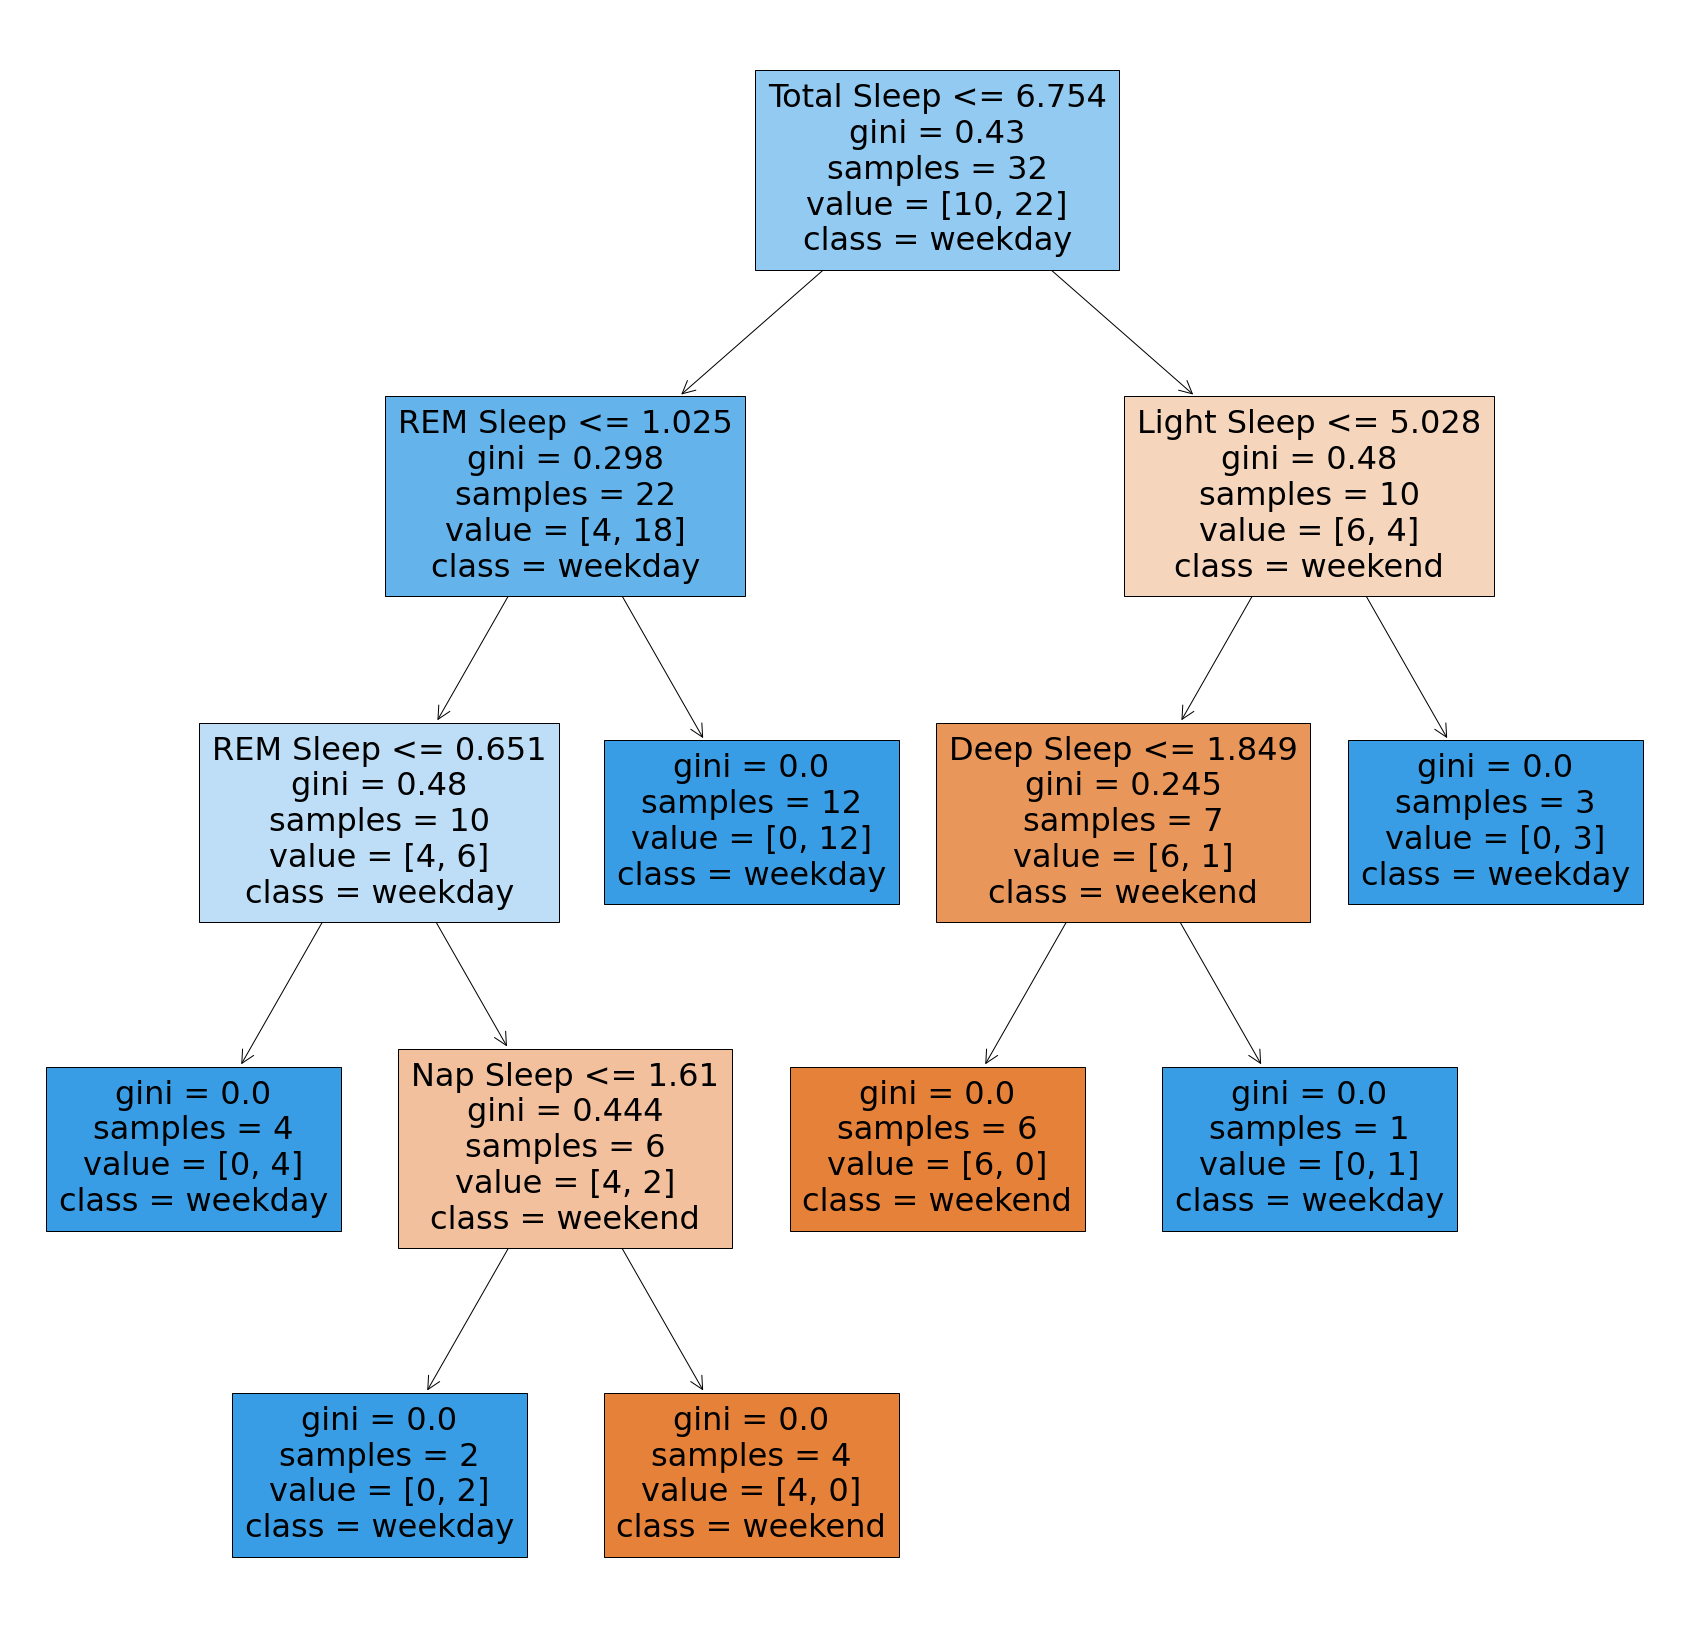

In [23]:
u.tree_clf_acc(X, y, class_names={1: "weekday", 0: "weekend"})

The decision tree has an accuracy rating of 85.7%, higher than the associated kNN. 

##### Number of Assignments

The second attribute I will be using as class information is "Number of Assignments".

In the combined dataset, there are 24 days with 0 assignments due, 13 days with 1 assignment due, 4 days with 2 assignments due, and 5 days with 3 assignments due. 

In [24]:
sleep_hw_df.value_counts('Number of Assignments')

Number of Assignments
0.0    24
1.0    13
3.0     5
2.0     4
dtype: int64

Predicting a test case:

In [25]:
data = sleep_hw_df.drop(columns=['Deep Sleep Percent', 'Light Sleep Percent', 'Nap Count', 'REM Sleep Percent', 'Weekday'], inplace=False)
test_case = [0.2, 2, 2, 0.3, 4.5, 0]
result = u.train_test(data, test_case=test_case, label='Number of Assignments')
#result_key = {0: "Test case is a Weekend", 1: "Test case is a Weekday"}
print(f'Predicted number of assignments: {result[0]}')


[0.15321083 1.32462278 1.50243306 0.378085   2.38641361 0.        ]
[2.08347194 5.72765944 2.41719024 2.16314167 8.70394472 6.        ]
[1.]
Predicted number of assignments: 1.0


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


This kNN model has an 83% accuracy rating, higher than the previous kNN but not predictive. 

In [26]:
X = sleep_hw_df.drop(columns=['Deep Sleep Percent', 'Light Sleep Percent', 'Nap Count', 'REM Sleep Percent', 'Number of Assignments'], inplace=False)
y = sleep_hw_df["Number of Assignments"].copy()
u.knn_clf_acc(X, y)

Accuracy: 0.8333333333333334


Decision tree classifier:

Accuracy: 0.5714285714285714


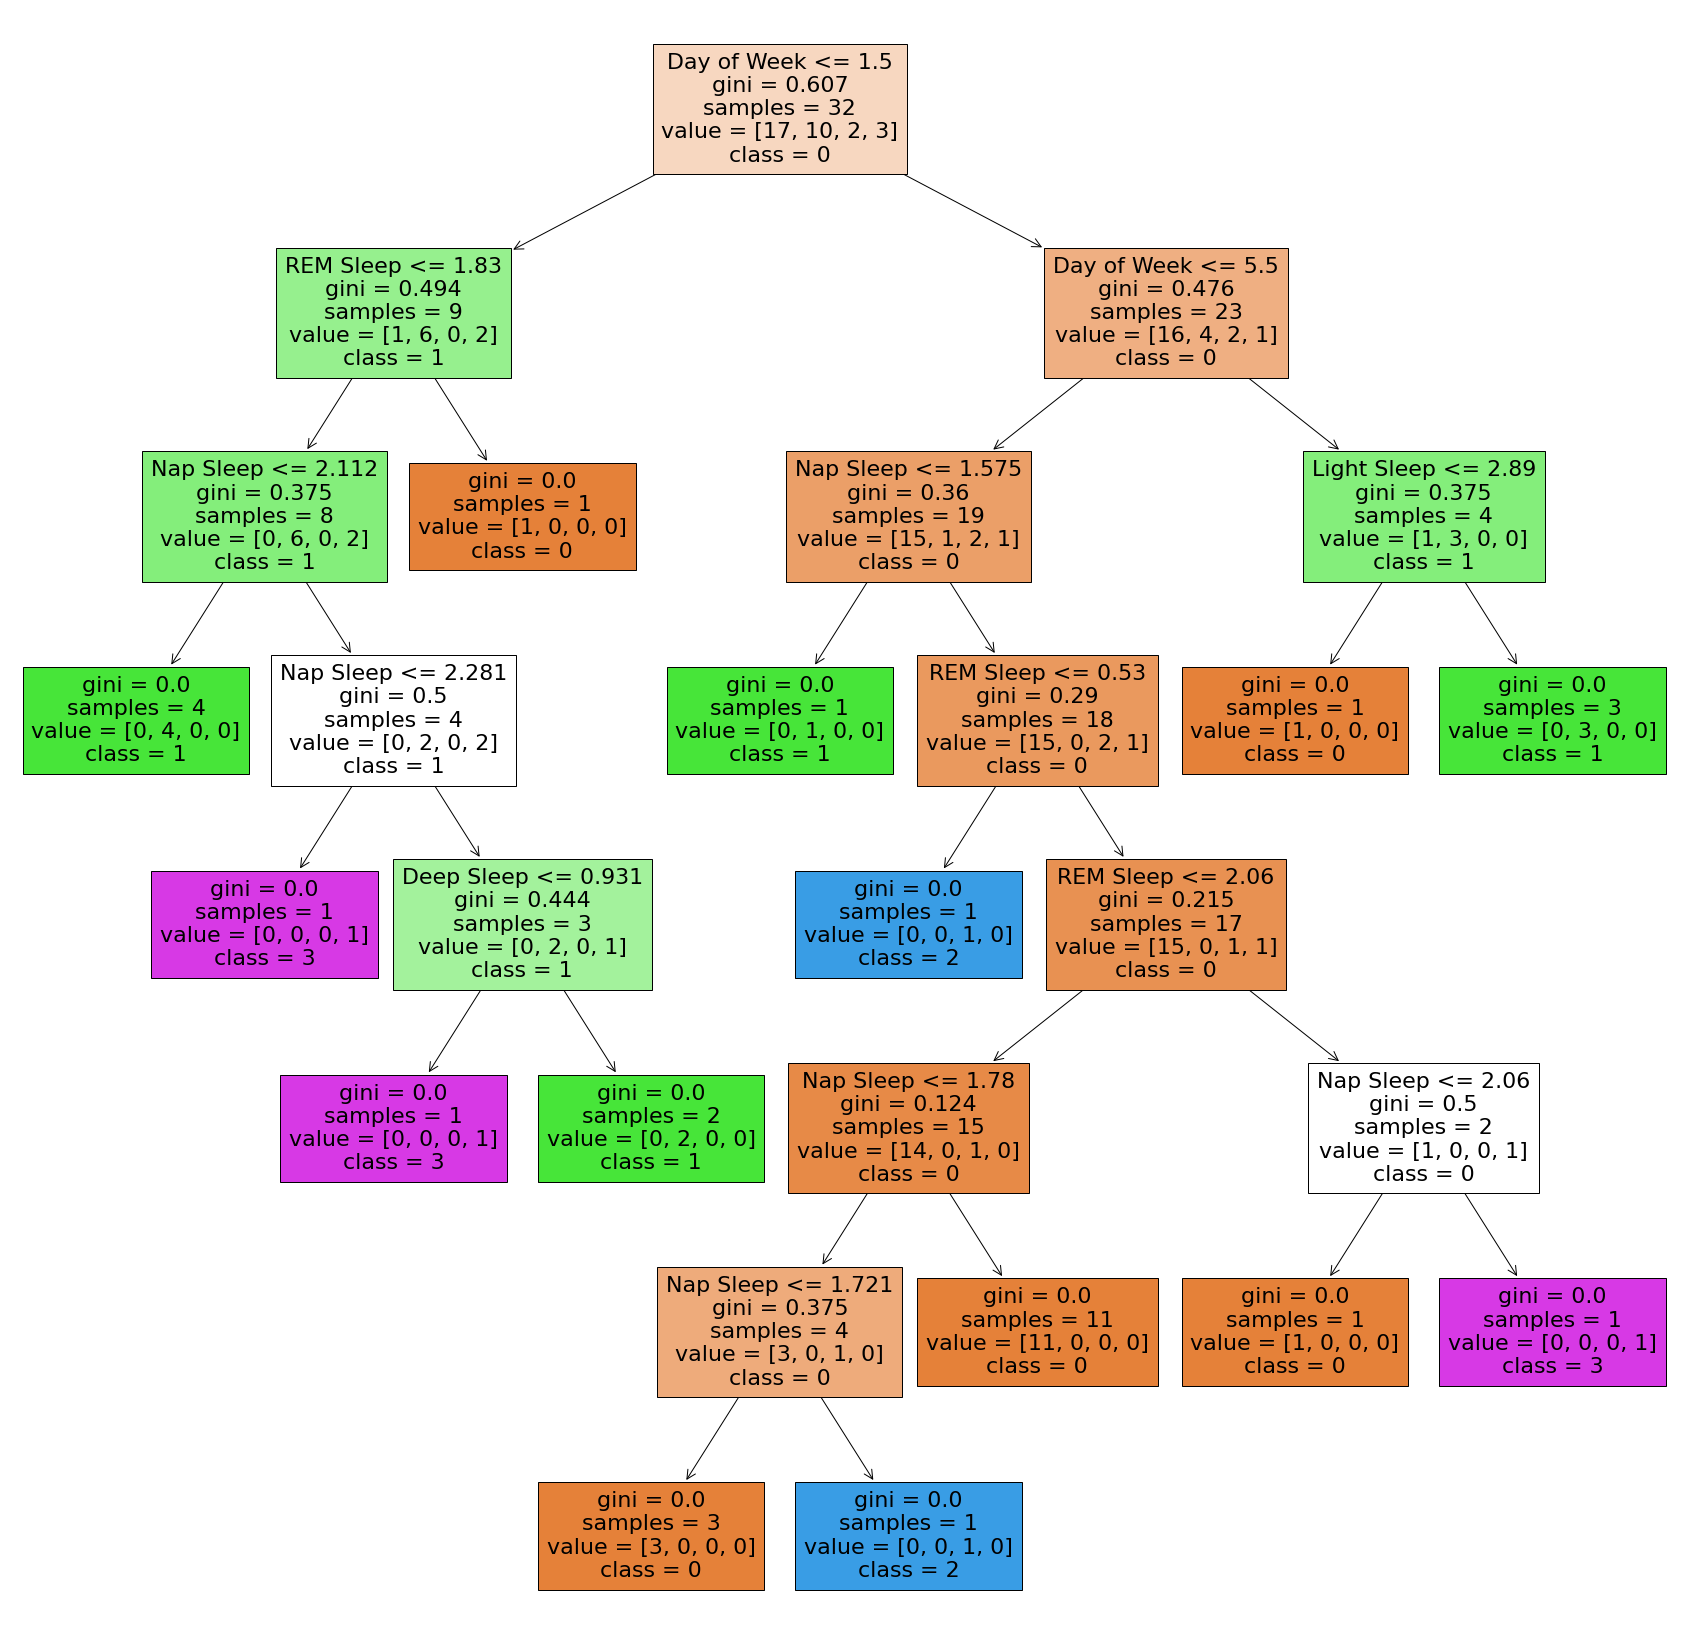

In [27]:
u.tree_clf_acc(X, y, class_names={0:'0', 1:'1', 2:'2', 3:'3'})

The second decision tree has a accuracy rating of 71.4%, lower than the associated kNN. 

## Conclusion

#### Summary

Overall, number of assignments and sleep is a fairly accurate indicator of whether it is a week day or a weekend, but it is more difficult to predict number of assignments based on sleep data and day of the week. The kNN model was able to predict number of assignments based on the breakdown of sleep and day of the week at an accuracy rate of 83%, but the decision tree only achieved 71.4% accuracy. For predicting whether the day was a weekend or week day, the kNN was 66% and the tree was 85%. Either way, I would need a larger dataset if I wanted more accurate results.

#### Classification Techniques

The classification techniques I used were predictive of day or assignments. The first was to determine whether it was a weekend or a week day based on the number of assignments I had, the amount of sleep I got, and the breakdown of the type of sleep. The second determined the number of assignments I had due based on the hours of sleep I got, the quality of sleep, and the day of the week. See [Classification Results](#classification-results) for documentation. In order to improve these models, I need more data. There weren't realistically enough instances to create a highly predictive model. Another way I would like to improve this model is to add more attributes, or use the percentage of each sleep type instead of the total hours. I think either of these could improve accuracy. 

#### Impact

The potential impact of this work and a follow up project would be the implications for predicting the amount of sleep students can get based on the amount of assignments they receive. This could be important for limiting homework in the classroom to ensure that students can get a healthy level of sleep. After covid, mental health levels are at an all time low. Improving sleep can improve overall mental well-being for students. 